Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install Augmentor

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin/Data/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin/Data/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

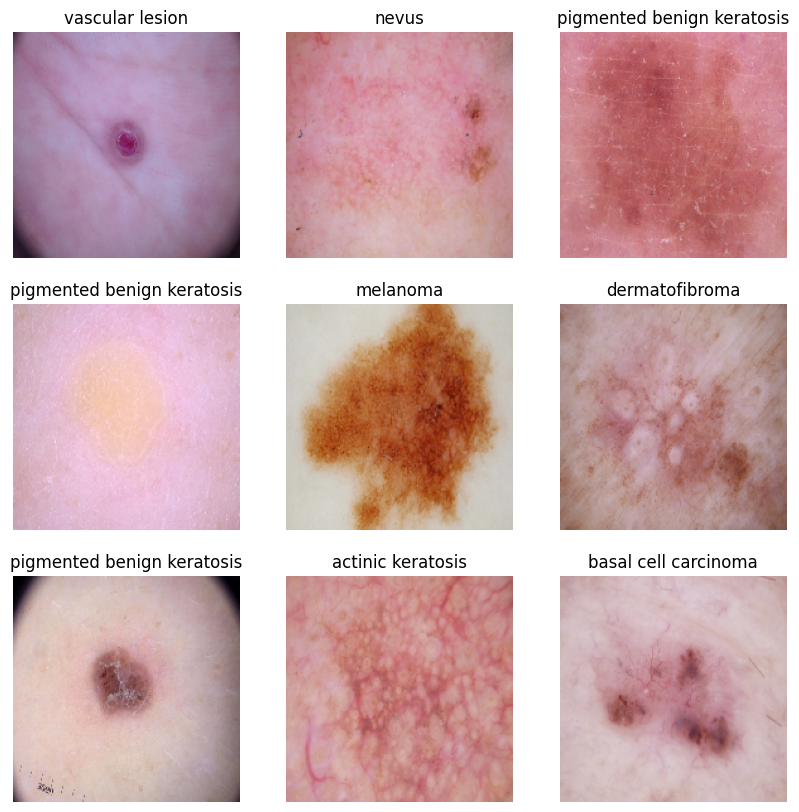

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 [==============================] - 81s 599ms/step - loss: 2.0566 - accuracy: 0.1894 - val_loss: 2.6218 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 6s 89ms/step - loss: 2.0173 - accuracy: 0.2278 - val_loss: 2.2609 - val_accuracy: 0.1525
Epoch 3/20
70/70 [==============================] - 6s 87ms/step - loss: 1.9214 - accuracy: 0.2662 - val_loss: 2.1817 - val_accuracy: 0.1864
Epoch 4/20
70/70 [==============================] - 6s 90ms/step - loss: 1.8271 - accuracy: 0.3104 - val_loss: 2.3020 - val_accuracy: 0.2797
Epoch 5/20
70/70 [==============================] - 6s 88ms/step - loss: 1.7302 - accuracy: 0.3725 - val_loss: 2.2447 - val_accuracy: 0.2373
Epoch 6/20
70/70 [==============================] - 6s 87ms/step - loss: 1.6115 - accuracy: 0.4105 - val_loss: 2.2873 - val_accuracy: 0.2627
Epoch 7/20
70/70 [==============================] - 6s 86ms/step - loss: 1.5777 - accuracy: 0.4194 - val_loss: 2.2237 - val_accuracy: 0.2373
Epoch 8/20
70/70 [====

### Visualizing training results

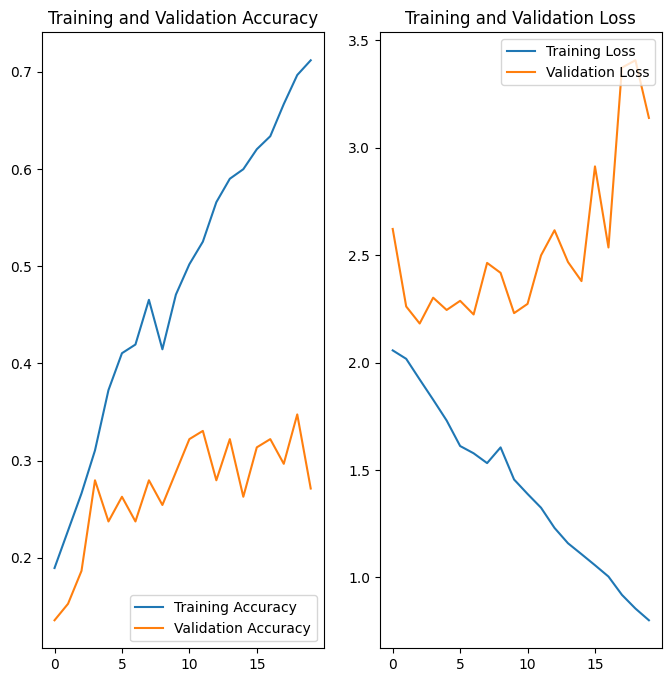

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 65-70% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

In [16]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

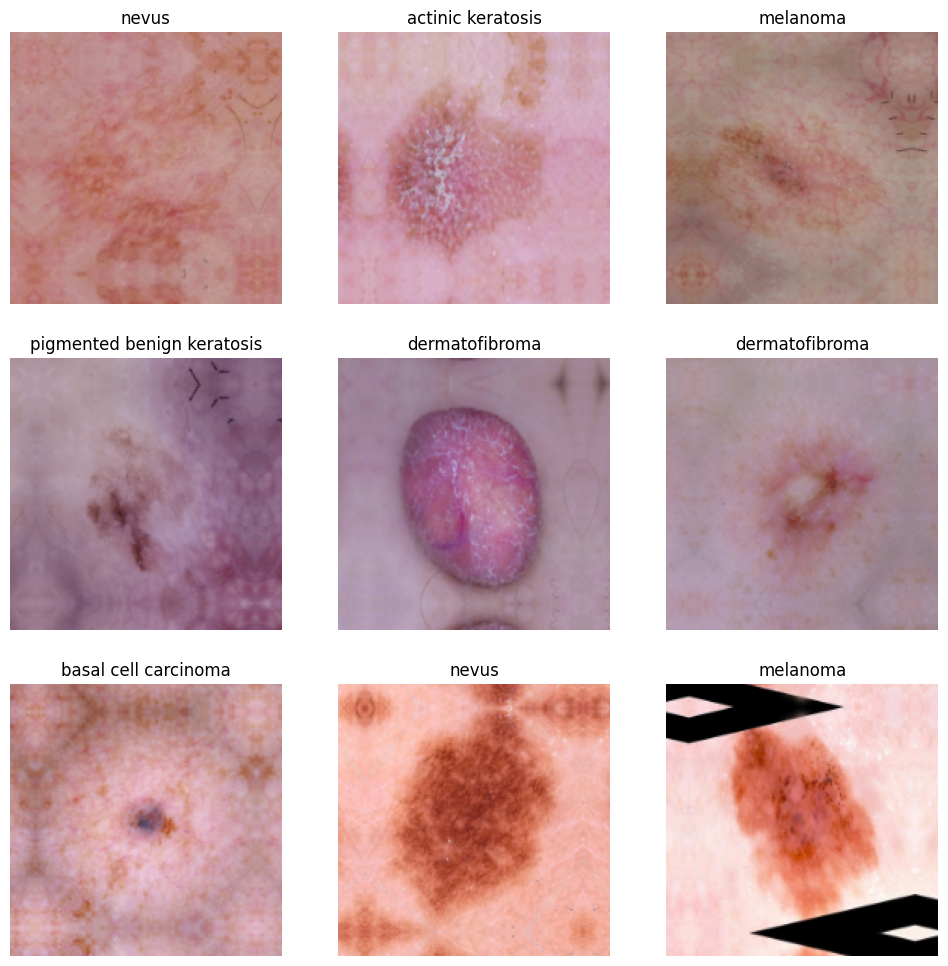

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [17]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Create the CNN model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [18]:
## Your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        51264     
                                                      

### Training the model

In [19]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 13s 130ms/step - loss: 1.9503 - accuracy: 0.2680 - val_loss: 2.2549 - val_accuracy: 0.2203
Epoch 2/20
70/70 [==============================] - 7s 103ms/step - loss: 1.7309 - accuracy: 0.3676 - val_loss: 2.2773 - val_accuracy: 0.2881
Epoch 3/20
70/70 [==============================] - 7s 103ms/step - loss: 1.5891 - accuracy: 0.4292 - val_loss: 2.0829 - val_accuracy: 0.2712
Epoch 4/20
70/70 [==============================] - 7s 102ms/step - loss: 1.6187 - accuracy: 0.4426 - val_loss: 2.2669 - val_accuracy: 0.3051
Epoch 5/20
70/70 [==============================] - 7s 102ms/step - loss: 1.5188 - accuracy: 0.4694 - val_loss: 2.2003 - val_accuracy: 0.3475
Epoch 6/20
70/70 [==============================] - 7s 102ms/step - loss: 1.4571 - accuracy: 0.5033 - val_loss: 2.3220 - val_accuracy: 0.3390
Epoch 7/20
70/70 [==============================] - 7s 100ms/step - loss: 1.4276 - accuracy: 0.5100 - val_loss: 2.0981 - val_accuracy: 0.3390
Epoch

### Visualizing the results

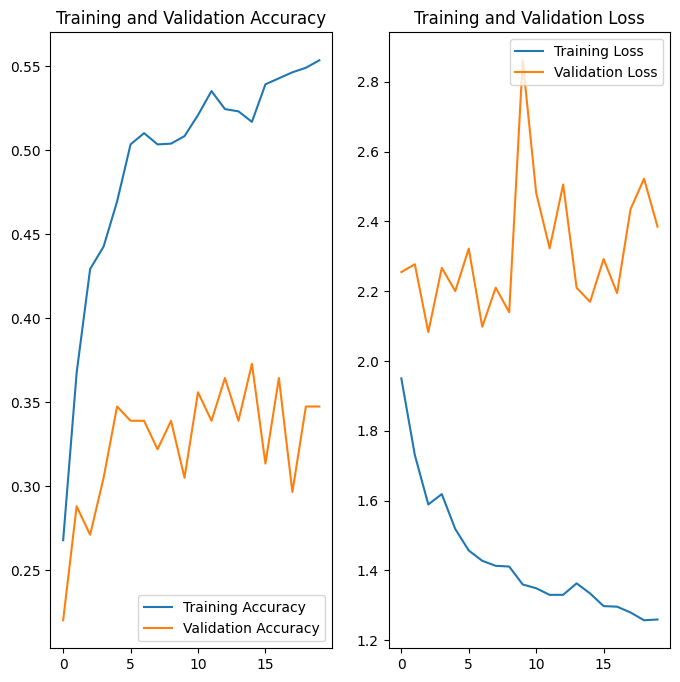

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

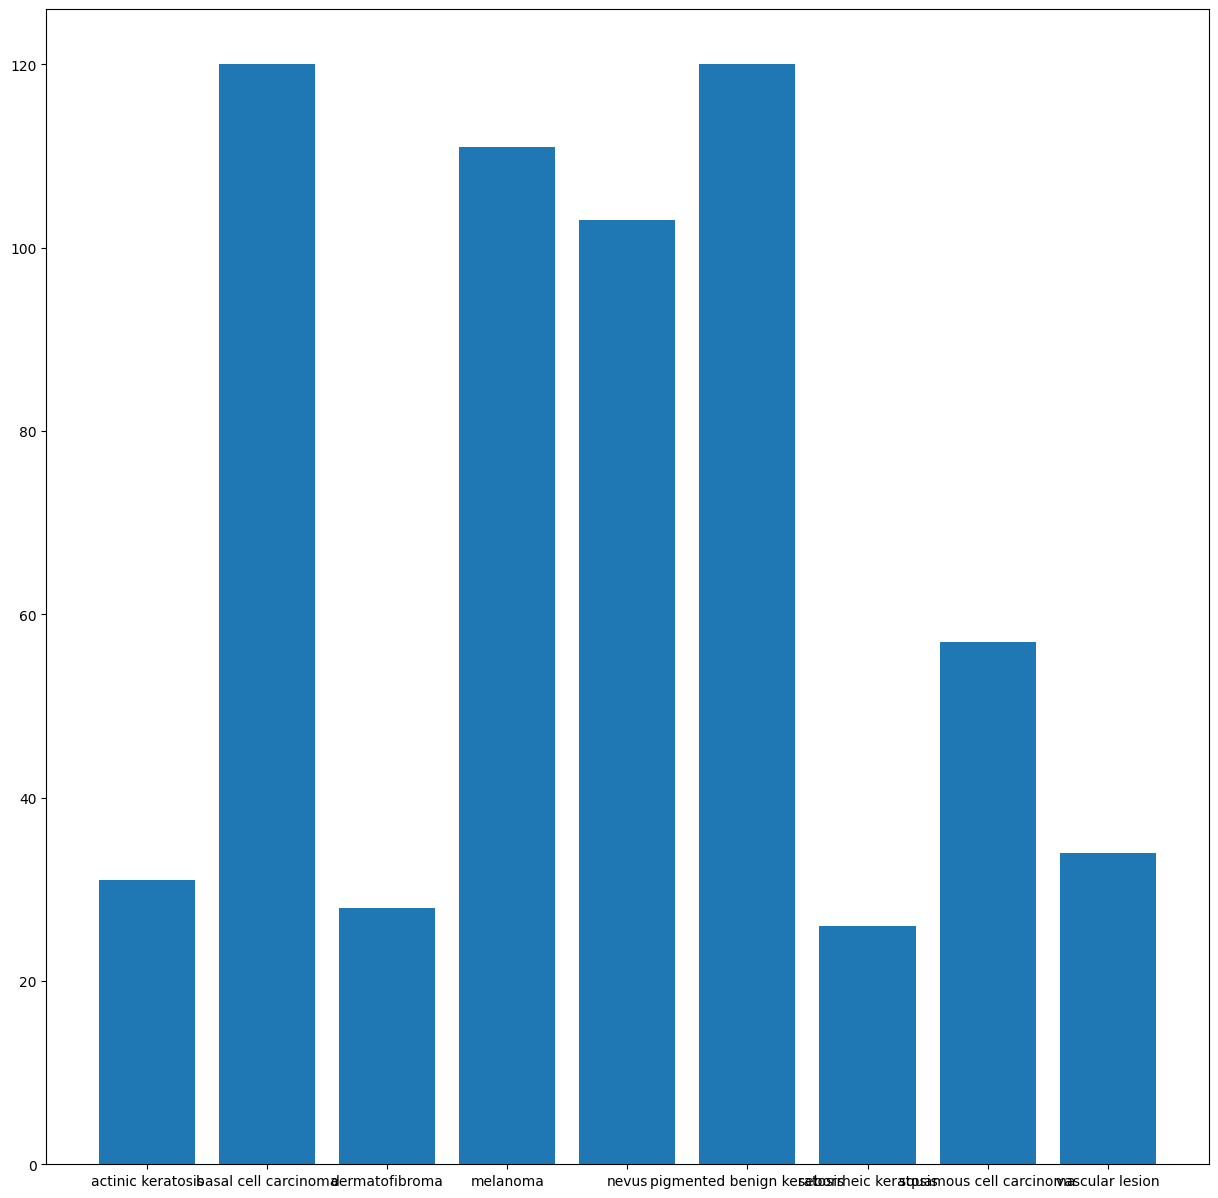

In [ ]:
## Your code goes here.
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Answer-1 :- squamous cell carcinoma has least number of samples

Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes.
melanoma and pigmented benign keratosis have proprtionate number of classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [21]:
import os
import Augmentor

# Path to your training dataset
path_to_training_dataset = "/content/gdrive/MyDrive/Skin/Data/Train"

for class_name in class_names:
    # Construct the full path
    class_path = os.path.join(path_to_training_dataset, class_name)

    # Check if the path exists
    if not os.path.exists(class_path):
        print(f"Directory does not exist: {class_path}")
        continue

    # Create a pipeline for each class directory
    p = Augmentor.Pipeline(class_path)

    # Define augmentation operations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate 500 samples
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EA55D1480>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1E42155030>: 100%|██████████| 500/500 [00:17<00:00, 28.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1E2A11D090>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1EA43DD600>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F1E803B6680>: 100%|██████████| 500/500 [01:12<00:00,  6.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EA441D360>: 100%|██████████| 500/500 [00:18<00:00, 26.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1E80241540>: 100%|██████████| 500/500 [00:40<00:00, 12.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1E803B6E90>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EA43DD630>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [22]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [23]:
from glob import glob

In [24]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_04f597e0-5d56-4bcb-a6e2-4c19e99d0748.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_65b4da10-77b1-449d-abdd-cd991bbf750c.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010391.jpg_ee703a4b-ed49-4e52-b644-182ef5299f5a.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010407.jpg_ad630860-f755-4cbd-b79f-d07423ba6191.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_893ac987-2a22-4195-ba58-c23299fb8a83.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0010982.jpg_39ae9ddf-322e-43ce-868c-51d0914e4848.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melanoma/output/melanoma_original_ISIC_0000395.jpg_1e44ec49-2282-4258-a35d-8ffe2074fa1a.jpg',
 '/content/gdrive/MyDrive/Skin/Data/Train/melano

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2

In [28]:
new_df['Label'].value_counts()

Label
melanoma                      500
actinic keratosis             500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
nevus                         500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (180,180,3)

#### **Todo:** Create a training dataset

In [30]:
import os
import shutil
import Augmentor

# Assuming class_names is a list of your class names

# Path to your training dataset
path_to_training_dataset = "/content/gdrive/MyDrive/Skin/Data/Train"

for class_name in class_names:
    # Construct the full path
    class_path = os.path.join(path_to_training_dataset, class_name)

    # Check if the path exists

    # Path to the output folder
    output_path = os.path.join(class_path, 'output')

    # Move files from output folder to main class folder
    if os.path.exists(output_path):
        for file_name in os.listdir(output_path):
            # Construct the full file path
            full_file_name = os.path.join(output_path, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, class_path)
        # Optionally remove the now empty output directory
        os.rmdir(output_path)
    else:
        print(f"Output directory does not exist: {output_path}")


In [31]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
model = Sequential()

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 20, 20, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print model summary
model.summary()

# Print some sample data from train_ds and val_ds
for batch in train_ds.take(1):
    images, labels = batch
    print("Train batch images shape:", images.shape)
    print("Train batch labels shape:", labels.shape)

for batch in val_ds.take(1):
    images, labels = batch
    print("Validation batch images shape:", images.shape)
    print("Validation batch labels shape:", labels.shape)

# Compile the model with eager execution for debugging
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Fit the model
#history = model.fit(train_ds, epochs=epochs, verbose=1, validation_data=val_ds, callbacks=[learning_rate_reduction])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 20, 20, 128)      

#### **Todo:**  Train your model

In [40]:
epochs =30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 228ms/step - loss: 12.6225 - accuracy: 0.1630 - val_loss: 2.1660 - val_accuracy: 0.1707
Epoch 2/30
169/169 [==============================] - 40s 231ms/step - loss: 2.2081 - accuracy: 0.1647 - val_loss: 2.1664 - val_accuracy: 0.1552
Epoch 3/30
169/169 [==============================] - 40s 228ms/step - loss: 2.2079 - accuracy: 0.1621 - val_loss: 2.1825 - val_accuracy: 0.1470
Epoch 4/30
169/169 [==============================] - 40s 228ms/step - loss: 2.1385 - accuracy: 0.1649 - val_loss: 2.1248 - val_accuracy: 0.1737
Epoch 5/30
169/169 [==============================] - 40s 228ms/step - loss: 2.1173 - accuracy: 0.1766 - val_loss: 2.1578 - val_accuracy: 0.1574
Epoch 6/30
169/169 [==============================] - 40s 228ms/step - loss: 2.1078 - accuracy: 0.1818 - val_loss: 2.1557 - val_accuracy: 0.1611
Epoch 7/30
169/169 [==============================] - 39s 226ms/step - loss: 2.0842 - accuracy: 0.1951 - val_loss: 2.1209 - val_a

#### **Todo:**  Visualize the model results

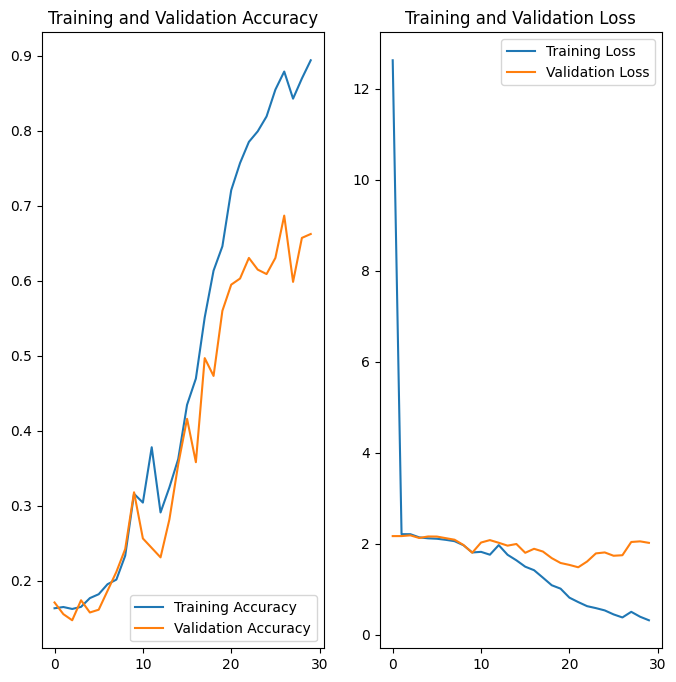

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter